In [65]:
import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('seaborn-whitegrid')
pd.set_option("display.precision", 5)

In [2]:
# magic to reload modules automatically
%load_ext autoreload
%autoreload 2

In [3]:
ff = pd.read_excel('data/5factors.xlsx')
rt = pd.read_excel('data/north.xlsx' , skiprows=3)
esg = pd.read_excel('data/north31.xlsx', skiprows=3)
print(rt.shape)
print(esg.shape)
print(ff.shape)

(2352, 124)
(12, 739)
(8261, 7)


In [4]:
pd.set_option('display.max_columns',735) # I want to see all the columns
pd.set_option('display.max_rows',735) 

In [5]:
ff.rename(columns = {'Unnamed: 0' : 'date'}, inplace=True)
ff['date'] = pd.to_datetime(ff['date'], format='%Y%m%d')
filt = (ff['date'] >= pd.to_datetime('2013-04-03')) & (ff['date'] <= pd.to_datetime('2022-02-28'))
ff = ff[filt]
ff.reset_index(inplace = True, drop = True)

In [6]:
rt.drop(index=[0,1,2], inplace=True)
rt.reset_index(inplace = True, drop = True) # Drop old index too

In [7]:
it = rt.copy()
it.to_excel('it.xlsx')

In [8]:
rt.rename(columns={'Unnamed: 0':'date'},inplace = True) 
xx = ['1COV GY Equity','DTG GY Equity','SINCH SS Equity',
                 'SHL GY Equity','NEL NO Equity','DHER GY Equity',
                 'HFG GY Equity','LIN GY Equity','NETS DC Equity',
                 'DAX Index','OMXS30B Index','OMXC25 Index','OMX Index']
drop_these = []
for i in xx:
    for j in range(1,6):
        drop_these.append(i + '.' + str(j))
drop_these = xx + drop_these
rt.drop(columns=xx, inplace = True)

In [9]:
rt.columns = rt.columns.str.replace(' GY', ' G')
rt.columns = rt.columns.str.replace(' SS', ' S')
rt.columns = rt.columns.str.replace(' NO', ' N')
rt.columns = rt.columns.str.replace(' DC', ' D')
rt.columns = rt.columns.str.replace(' Equity', '')
rt.columns = rt.columns.str.replace(' ', '_')

In [10]:
rt['date'] = pd.to_datetime(rt['date'])
#rt.set_index('date',inplace = True) 

In [11]:
esg.drop(columns=drop_these,inplace = True) 
esg.drop(index=[0,2], inplace=True)
esg.rename(columns={'Unnamed: 0':'Date'},inplace = True) 
esg.reset_index(inplace = True, drop = True) 

In [12]:
esg.replace({'ESG_DISCLOSURE_SCORE': 'ESG', 'ENVIRON_DISCLOSURE_SCORE': 'E',
             'SOCIAL_DISCLOSURE_SCORE': 'S','GOVNCE_DISCLOSURE_SCORE': 'G',
             'HISTORICAL_MARKET_CAP' : 'HMCAP', 'CUR_MKT_CAP': 'MCAP'}, inplace=True)

In [13]:
asg = esg.iloc[1] + ' ' + esg.iloc[0]
esg = esg.append(asg, ignore_index=True)
esg.loc[10,'Date'] = 'date'
nnn = esg.loc[10]
esg.rename(columns=nnn, inplace=True)
esg.drop(index=[0,1,10], inplace=True)
esg.reset_index(inplace = True, drop = True)

In [14]:
esg.columns = esg.columns.str.replace(' GY', ' G')
esg.columns = esg.columns.str.replace(' SS', ' S')
esg.columns = esg.columns.str.replace(' NO', ' N')
esg.columns = esg.columns.str.replace(' DC', ' D')
esg.columns = esg.columns.str.replace(' Equity', '')
esg.columns = esg.columns.str.replace(' ', '_')
esg.set_index('date', inplace=True)

In [15]:
esg_esg = esg.loc[:,'ADS_G_ESG':'VWS_D_ESG']
esg_esg.columns = esg_esg.columns.str.replace('_ESG', '')

In [16]:
for i in rt.columns[1:]:
    rt.loc[:,i] = rt.loc[:,i].pct_change(1)*100
rt.drop(index=[0], inplace=True)

In [17]:
nyind = []
for i in esg_esg.index:
    nyind.append(str(i)+ '_esg')
esg_esg.index = nyind

In [18]:
rtt = pd.concat([rt, esg_esg])

In [19]:
#rtt.drop(columns='EVO_S', inplace=True)
#rt.drop(columns='EVO_S', inplace=True)
no_ger = rtt.columns[1:35].tolist()
rtt.drop(columns=no_ger, inplace=True)
rt.drop(columns=no_ger, inplace=True)
esg_esg.drop(columns=no_ger, inplace=True)

In [20]:
filt = (rtt['date'] >= pd.to_datetime('2013-01-01')) & (rtt['date'] <= pd.to_datetime('2013-12-31')) 
thirteen = rtt[filt]
thirteen = pd.concat([thirteen, esg_esg])
thirteen = thirteen.replace(0, np.nan)
thirteen.dropna(how='all', axis='columns', thresh=150, inplace=True)
thirteen = thirteen.replace(np.nan, 0)
nah = ['2015_esg','2016_esg','2017_esg','2018_esg','2019_esg','2020_esg','2021_esg']
thirteen.drop(index=nah, inplace=True)
print(thirteen.shape)

(196, 71)


In [21]:
#  2013
q_l = thirteen.loc[thirteen.index[-1], 'ABB_S' : 'VWS_D'].quantile(0.33)
q_h = thirteen.loc[thirteen.index[-1], 'ABB_S' : 'VWS_D'].quantile(0.67)
I = (thirteen.loc['2014_esg', 'ABB_S':'VWS_D'] <= q_l)
Ii = (thirteen.loc['2014_esg', 'ABB_S':'VWS_D'] > q_l) & (thirteen.loc['2014_esg', 'ABB_S':'VWS_D'] <= q_h)
Iii = (thirteen.loc['2014_esg', 'ABB_S':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum
thirteen = thirteen.sort_values(by = '2014_esg', axis = 1, na_position ='first')
thirteen_low = I[I==True].index.tolist()
thirteen_mid = Ii[Ii==True].index.tolist()
thirteen_high = Iii[Iii==True].index.tolist()

In [22]:
#2013
# low
thirteen = thirteen.iloc[:-1]
low_p=[]
for i in range(len(thirteen)):
     low_p.append(thirteen.iloc[i, 1:I_sum].mean())

# mid
mid_p=[]
for i in range(len(thirteen)):
     mid_p.append(thirteen.iloc[i, I_sum:Ii_sum].mean())

# high
high_p=[]
for i in range(len(thirteen)):
     high_p.append(thirteen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [23]:
filt = (rtt['date'] >= pd.to_datetime('2014-01-01')) & (rtt['date'] <= pd.to_datetime('2014-12-31')) 
fourteen = rtt[filt]
fourteen = pd.concat([fourteen, esg_esg])
fourteen = fourteen.replace(0, np.nan)
fourteen.dropna(how='all', axis='columns', thresh=100, inplace=True)
fourteen = fourteen.replace(np.nan, 0)
nah = ['2015_esg','2016_esg','2017_esg','2018_esg','2019_esg','2020_esg','2021_esg']
fourteen.drop(index=nah, inplace=True)
fourteen.sort_values(by = '2014_esg', axis = 1, na_position ='first', inplace=True)

In [24]:
#2014
# low
fourteen = fourteen.iloc[:-1]
for i in range(len(fourteen)):
     low_p.append(fourteen.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(fourteen)):
     mid_p.append(fourteen.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(fourteen)):
     high_p.append(fourteen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [25]:
#  2015
filt = (rtt['date'] >= pd.to_datetime('2015-01-01')) & (rtt['date'] <= pd.to_datetime('2015-12-31')) 
fifteen = rtt[filt]
fifteen = pd.concat([fifteen, esg_esg])
fifteen = fifteen.replace(0, np.nan)
fifteen.dropna(how='all', axis='columns', thresh=100, inplace=True)
fifteen = fifteen.replace(np.nan, 0)
nah = ['2014_esg','2016_esg','2017_esg','2018_esg','2019_esg','2020_esg','2021_esg']
fifteen.drop(index=nah, inplace=True)

q_l = fifteen.loc[fifteen.index[-1], 'ABB_S' : 'VWS_D'].quantile(0.33)
q_h = fifteen.loc[fifteen.index[-1], 'ABB_S' : 'VWS_D'].quantile(0.67)
I = (fifteen.loc['2015_esg', 'ABB_S':'VWS_D'] <= q_l)
Ii = (fifteen.loc['2015_esg', 'ABB_S':'VWS_D'] > q_l) & (fifteen.loc['2015_esg', 'ABB_S':'VWS_D'] <= q_h)
Iii = (fifteen.loc['2015_esg', 'ABB_S':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum
fifteen_low = I[I==True].index.tolist()
fifteen_mid = Ii[Ii==True].index.tolist()
fifteen_high = Iii[Iii==True].index.tolist()

In [26]:
print(fifteen.shape)
Iii.sum()

(262, 75)


25

In [27]:
fifteen.sort_values(by = '2015_esg', axis = 1, na_position ='first', inplace=True)

In [28]:
#2015
# low
fifteen = fifteen.iloc[:-1]
for i in range(len(fifteen)):
     low_p.append(fifteen.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(fifteen)):
     mid_p.append(fifteen.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(fifteen)):
     high_p.append(fifteen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [29]:
#  2016
filt = (rtt['date'] >= pd.to_datetime('2016-01-01')) & (rtt['date'] <= pd.to_datetime('2016-12-31')) 
sixteen = rtt[filt]
sixteen = pd.concat([sixteen, esg_esg])
sixteen = sixteen.replace(0, np.nan)
sixteen.dropna(how='all', axis='columns', thresh=120, inplace=True)
sixteen = sixteen.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2017_esg','2018_esg','2019_esg','2020_esg','2021_esg']
sixteen.drop(index=nah, inplace=True)

q_l = sixteen.loc[sixteen.index[-1], 'ABB_S' : 'VWS_D'].quantile(q=0.33)
q_h = sixteen.loc[sixteen.index[-1], 'ABB_S' : 'VWS_D'].quantile(q=0.67)
I = (sixteen.loc['2016_esg', 'ABB_S':'VWS_D'] <= q_l)
Ii = (sixteen.loc['2016_esg', 'ABB_S':'VWS_D'] > q_l) & (sixteen.loc['2016_esg', 'ABB_S':'VWS_D'] <= q_h)
Iii = (sixteen.loc['2016_esg', 'ABB_S':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum
sixteen_low = I[I==True].index.tolist()
sixteen_mid = Ii[Ii==True].index.tolist()
sixteen_high = Iii[Iii==True].index.tolist()
print(sixteen.shape)
print(I_sum)
print(Ii_sum)
print(Iii_sum)

(262, 76)
25
50
75


In [30]:
print(sixteen.shape)


(262, 76)


In [31]:
sixteen.sort_values(by = '2016_esg', axis = 1, na_position ='first', inplace=True)

In [32]:
#  2016
# low
sixteen = sixteen.iloc[:-1]
for i in range(len(sixteen)):
     low_p.append(sixteen.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(sixteen)):
     mid_p.append(sixteen.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(sixteen)):
     high_p.append(sixteen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [33]:
#  2017
filt = (rtt['date'] >= pd.to_datetime('2017-01-01')) & (rtt['date'] <= pd.to_datetime('2017-12-31')) 
seventeen = rtt[filt]
seventeen = pd.concat([seventeen, esg_esg])
seventeen = seventeen.replace(0, np.nan)
seventeen.dropna(how='all', axis='columns', thresh=120, inplace=True)
seventeen = seventeen.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2016_esg','2018_esg','2019_esg','2020_esg','2021_esg']
seventeen.drop(index=nah, inplace=True)

q_l = seventeen.loc[seventeen.index[-1], 'ABB_S' : 'VWS_D'].quantile(q=0.333)
q_h = seventeen.loc[seventeen.index[-1], 'ABB_S' : 'VWS_D'].quantile(q=0.67)
I = (seventeen.loc['2017_esg', 'ABB_S':'VWS_D'] <= q_l)
Ii = (seventeen.loc['2017_esg', 'ABB_S':'VWS_D'] > q_l) & (seventeen.loc['2017_esg', 'ABB_S':'VWS_D'] < q_h)
Iii = (seventeen.loc['2017_esg', 'ABB_S':'VWS_D'] >= q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum
seventeen_low = I[I==True].index.tolist()
seventeen_mid = Ii[Ii==True].index.tolist()
seventeen_high = Iii[Iii==True].index.tolist()
print(seventeen.shape)
print(I_sum)
print(Ii_sum)
print(Iii_sum)

(261, 77)
25
51
76


In [34]:
seventeen.sort_values(by = '2017_esg', axis = 1, na_position ='first', inplace=True)

In [35]:
#  2017
# low
seventeen = seventeen.iloc[:-1]
for i in range(len(seventeen)):
     low_p.append(seventeen.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(seventeen)):
     mid_p.append(seventeen.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(seventeen)):
     high_p.append(seventeen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [36]:
#  2018
filt = (rtt['date'] >= pd.to_datetime('2018-01-01')) & (rtt['date'] <= pd.to_datetime('2018-12-31')) 
eighteen  = rtt[filt]
eighteen = pd.concat([eighteen, esg_esg])
eighteen = eighteen.replace(0, np.nan)
eighteen.dropna(how='all', axis='columns', thresh=120, inplace=True)
eighteen = eighteen.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2016_esg','2017_esg','2019_esg','2020_esg','2021_esg']
eighteen.drop(index=nah, inplace=True)

q_l = eighteen.loc[eighteen.index[-1], 'ABB_S' : 'VWS_D'].quantile(q=0.333)
q_h = eighteen.loc[eighteen.index[-1], 'ABB_S' : 'VWS_D'].quantile(q=0.67)
I = (eighteen.loc['2018_esg', 'ABB_S':'VWS_D'] <= q_l)
Ii = (eighteen.loc['2018_esg', 'ABB_S':'VWS_D'] > q_l) & (eighteen.loc['2018_esg', 'ABB_S':'VWS_D'] <= q_h)
Iii = (eighteen.loc['2018_esg', 'ABB_S':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum
eighteen_low = I[I==True].index.tolist()
eighteen_mid = Ii[Ii==True].index.tolist()
eighteen_high = Iii[Iii==True].index.tolist()

In [37]:
eighteen.sort_values(by = '2018_esg', axis = 1, na_position ='first', inplace=True)

In [38]:
#  2018
# low
eighteen = eighteen.iloc[:-1]
for i in range(len(eighteen)):
     low_p.append(eighteen.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(eighteen)):
     mid_p.append(eighteen.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(eighteen)):
     high_p.append(eighteen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [39]:
#  2019
filt = (rtt['date'] >= pd.to_datetime('2019-01-01')) & (rtt['date'] <= pd.to_datetime('2019-12-31')) 
nineteen  = rtt[filt]
nineteen = pd.concat([nineteen, esg_esg])
nineteen = nineteen.replace(0, np.nan)
nineteen = nineteen.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2016_esg','2017_esg','2018_esg','2020_esg','2021_esg']
nineteen.drop(index=nah, inplace=True)

q_l = nineteen.loc[nineteen.index[-1], 'ABB_S' : 'VWS_D'].quantile(q=0.333)
q_h = nineteen.loc[nineteen.index[-1], 'ABB_S' : 'VWS_D'].quantile(q=0.67)
I = (nineteen.loc['2019_esg', 'ABB_S':'VWS_D'] <= q_l)
Ii = (nineteen.loc['2019_esg', 'ABB_S':'VWS_D'] > q_l) & (nineteen.loc['2019_esg', 'ABB_S':'VWS_D'] <= q_h)
Iii = (nineteen.loc['2019_esg', 'ABB_S':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum
nineteen_low = I[I==True].index.tolist()
nineteen_mid = Ii[Ii==True].index.tolist()
nineteen_high = Iii[Iii==True].index.tolist()

In [40]:
nineteen.sort_values(by = '2019_esg', axis = 1, na_position ='first', inplace=True)

In [41]:
#  2019
# low
nineteen = nineteen.iloc[:-1]
for i in range(len(nineteen)):
     low_p.append(nineteen.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(nineteen)):
     mid_p.append(nineteen.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(nineteen)):
     high_p.append(nineteen.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [42]:
#  2020
filt = (rtt['date'] >= pd.to_datetime('2020-01-01')) & (rtt['date'] <= pd.to_datetime('2020-12-31')) 
twenty   = rtt[filt]
twenty = pd.concat([twenty, esg_esg])
twenty = twenty.replace(0, np.nan)
twenty = twenty.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2016_esg','2017_esg','2018_esg','2019_esg','2021_esg']
twenty.drop(index=nah, inplace=True)

q_l = twenty.loc[twenty.index[-1], 'ABB_S' : 'VWS_D'].quantile(q=0.333)
q_h = twenty.loc[twenty.index[-1], 'ABB_S' : 'VWS_D'].quantile(q=0.67)
I = (twenty.loc['2020_esg', 'ABB_S':'VWS_D'] <= q_l)
Ii = (twenty.loc['2020_esg', 'ABB_S':'VWS_D'] > q_l) & (twenty.loc['2020_esg', 'ABB_S':'VWS_D'] <= q_h)
Iii = (twenty.loc['2020_esg', 'ABB_S':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum
twenty_low = I[I==True].index.tolist()
twenty_mid = Ii[Ii==True].index.tolist()
twenty_high = Iii[Iii==True].index.tolist()

In [43]:
twenty.sort_values(by = '2020_esg', axis = 1, na_position ='first', inplace=True)

In [44]:
#  2020
# low
twenty = twenty.iloc[:-1]
for i in range(len(twenty)):
     low_p.append(twenty.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(twenty)):
     mid_p.append(twenty.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(twenty)):
     high_p.append(twenty.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [45]:
#  2021
filt = (rtt['date'] >= pd.to_datetime('2021-01-01')) & (rtt['date'] <= pd.to_datetime('2021-12-31')) 
twentyone = rtt[filt]
twentyone = pd.concat([twentyone, esg_esg])
twentyone = twentyone.replace(0, np.nan)
twentyone = twentyone.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2016_esg','2017_esg','2018_esg','2019_esg','2020_esg']
twentyone.drop(index=nah, inplace=True)

q_l = twentyone.loc[twentyone.index[-1], 'ABB_S' : 'VWS_D'].quantile(q=0.333)
q_h = twentyone.loc[twentyone.index[-1], 'ABB_S' : 'VWS_D'].quantile(q=0.67)
I = (twentyone.loc['2021_esg', 'ABB_S':'VWS_D'] <= q_l)
Ii = (twentyone.loc['2021_esg', 'ABB_S':'VWS_D'] > q_l) & (twentyone.loc['2021_esg', 'ABB_S':'VWS_D'] <= q_h)
Iii = (twentyone.loc['2021_esg', 'ABB_S':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum
twentyone_low = I[I==True].index.tolist()
twentyone_mid = Ii[Ii==True].index.tolist()
twentyone_high = Iii[Iii==True].index.tolist()

In [46]:
twentyone.sort_values(by = '2021_esg', axis = 1, na_position ='first', inplace=True)

In [47]:
#  2021
# low
twentyone = twentyone.iloc[:-1]
for i in range(len(twentyone)):
     low_p.append(twentyone.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(twentyone)):
     mid_p.append(twentyone.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(twentyone)):
     high_p.append(twentyone.iloc[i, Ii_sum:Iii_sum + 1].mean())

In [48]:
#  2022
filt = (rtt['date'] >= pd.to_datetime('2022-01-01')) & (rtt['date'] <= pd.to_datetime('2022-04-02')) 
twentytwo = rtt[filt]
twentytwo = pd.concat([twentytwo, esg_esg])
twentytwo = twentytwo.replace(0, np.nan)
twentytwo = twentytwo.replace(np.nan, 0)
nah = ['2014_esg','2015_esg','2016_esg','2017_esg','2018_esg','2019_esg','2020_esg']
twentytwo.drop(index=nah, inplace=True)

q_l = twentytwo.loc[twentytwo.index[-1], 'ABB_S' : 'VWS_D'].quantile(q=0.333)
q_h = twentytwo.loc[twentytwo.index[-1], 'ABB_S' : 'VWS_D'].quantile(q=0.67)
I = (twentytwo.loc['2021_esg', 'ABB_S':'VWS_D'] <= q_l)
Ii = (twentytwo.loc['2021_esg', 'ABB_S':'VWS_D'] > q_l) & (twentytwo.loc['2021_esg', 'ABB_S':'VWS_D'] <= q_h)
Iii = (twentytwo.loc['2021_esg', 'ABB_S':'VWS_D'] > q_h)
I_sum = I.sum()
Ii_sum = Ii.sum() + I_sum
Iii_sum = Iii.sum() + Ii_sum
twentytwo_low = I[I==True].index.tolist()
twentytwo_mid = Ii[Ii==True].index.tolist()
twentytwo_high = Iii[Iii==True].index.tolist()

In [49]:
twentytwo.sort_values(by = '2021_esg', axis = 1, na_position ='first', inplace=True)

In [50]:
#  2022
# low
twentytwo = twentytwo.iloc[:-1]
for i in range(len(twentytwo)):
     low_p.append(twentytwo.iloc[i, 1:I_sum].mean())

# mid
for i in range(len(twentytwo)):
     mid_p.append(twentytwo.iloc[i, I_sum:Ii_sum].mean())

# high
for i in range(len(twentytwo)):
     high_p.append(twentytwo.iloc[i, Ii_sum:Iii_sum + 1].mean())

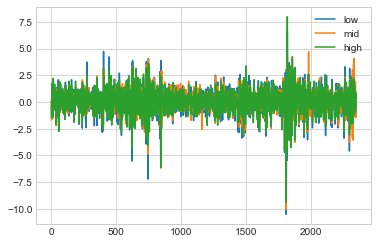

In [51]:
plt.plot(low_p, label = 'low')
plt.plot(mid_p, label = 'mid')
plt.plot(high_p, label = 'high')
plt.legend();

In [52]:
rt['port_low'] = low_p
rt['port_mid'] = mid_p
rt['port_high'] = high_p

In [53]:
rt.to_excel('rt.xlsx')
ff.to_excel('ff.xlsx')
esg_esg.to_excel('esg_esg.xlsx')

In [54]:
test = rt.copy()
test = test.replace(0, np.nan)
test.dropna(how='all', axis='index', thresh=4, inplace=True)
test = test.replace(np.nan, 0)
tab = test.describe()

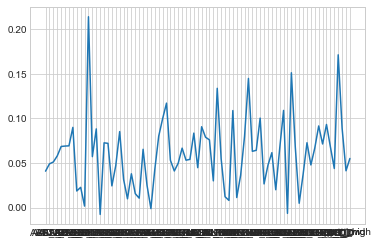

In [55]:
plt.plot(tab.loc['mean',:]);

In [56]:
high_r = tab.loc['mean',:].sort_values(ascending=False).tolist()
tab.loc['mean',:].sort_values(ascending=False).head()

EVO_S      0.21407
VWS_D      0.17137
GMAB_D     0.15125
AMBUB_D    0.14490
SALM_N     0.13380
Name: mean, dtype: float64

In [57]:
tabl = []
for i in range (40):
    tabl.append(0+i)
tabl = pd.DataFrame(tabl)    

In [58]:
tabl['2013_low'] = pd.DataFrame(thirteen_low)
tabl['2013_mid'] = pd.DataFrame(thirteen_mid)
tabl['2013_high'] = pd.DataFrame(thirteen_high)
tabl['2014_low'] = pd.DataFrame(thirteen_low)
tabl['2014_mid'] = pd.DataFrame(thirteen_mid)
tabl['2014_high'] = pd.DataFrame(thirteen_high)
tabl['2015_low'] = pd.DataFrame(fifteen_low)
tabl['2015_mid']= pd.DataFrame(fifteen_mid)
tabl['2015_high'] = pd.DataFrame(fifteen_high)
tabl['2016_low']= pd.DataFrame(sixteen_low)
tabl['2016_mid'] = pd.DataFrame(sixteen_mid)
tabl['2016_high'] = pd.DataFrame(sixteen_high)
tabl['2017_low'] = pd.DataFrame(seventeen_low)
tabl['2017_mid'] = pd.DataFrame(seventeen_mid)
tabl['2017_high'] = pd.DataFrame(seventeen_high)
tabl['2018_low'] = pd.DataFrame(eighteen_low)
tabl['2018_mid'] = pd.DataFrame(eighteen_mid)
tabl['2018_high'] = pd.DataFrame(eighteen_high)
tabl['2019_low'] = pd.DataFrame(nineteen_low)
tabl['2019_mid'] = pd.DataFrame(nineteen_mid)
tabl['2019_high'] = pd.DataFrame(nineteen_high)
tabl['2020_low'] = pd.DataFrame(twenty_low)
tabl['2020_mid'] = pd.DataFrame(twenty_mid)
tabl['2020_high'] = pd.DataFrame(twenty_high)
tabl['2021_low'] = pd.DataFrame(twentyone_low)
tabl['2021_mid'] = pd.DataFrame(twentyone_mid)
tabl['2021_high'] = pd.DataFrame(twentyone_high)
tabl['2022_low']  = pd.DataFrame(twentytwo_low)
tabl['2022_mid'] = pd.DataFrame(twentytwo_mid)
tabl['2022_high'] = pd.DataFrame(twentytwo_high)

In [59]:
#print(tabl.to_latex(index = True, multirow = True))

In [60]:
#tabl.to_excel('tabl.xlsx')

In [61]:
tabl

,0,2013_low,2013_mid,2013_high,2014_low,2014_mid,2014_high,2015_low,2015_mid,2015_high,2016_low,2016_mid,2016_high,2017_low,2017_mid,2017_high,2018_low,2018_mid,2018_high,2019_low,2019_mid,2019_high,2020_low,2020_mid,2020_high,2021_low,2021_mid,2021_high,2022_low,2022_mid,2022_high
0,0,ALIV_S,ASSAB_S,ABB_S,ALIV_S,ASSAB_S,ABB_S,EVO_S,ALIV_S,ABB_S,EVO_S,ALIV_S,ABB_S,EVO_S,ALFA_S,ABB_S,EVO_S,ALFA_S,ABB_S,EVO_S,ALFA_S,ABB_S,EVO_S,ALFA_S,ABB_S,EVO_S,ALFA_S,ABB_S,EVO_S,ALFA_S,ABB_S
1,1,GETIB_S,HEXAB_S,ALFA_S,GETIB_S,HEXAB_S,ALFA_S,GETIB_S,HMB_S,ALFA_S,GETIB_S,ATCOA_S,ALFA_S,HEXAB_S,ATCOA_S,ALIV_S,HEXAB_S,ATCOA_S,ALIV_S,HEXAB_S,ASSAB_S,ALIV_S,HEXAB_S,ASSAB_S,ALIV_S,HEXAB_S,ASSAB_S,ALIV_S,HEXAB_S,ASSAB_S,ALIV_S
2,2,INVEB_S,HMB_S,ATCOA_S,INVEB_S,HMB_S,ATCOA_S,HEXAB_S,NDA_S,ASSAB_S,HEXAB_S,ATCOB_S,ASSAB_S,INVEB_S,ATCOB_S,ASSAB_S,INVEB_S,ATCOB_S,ASSAB_S,INVEB_S,GETIB_S,ATCOA_S,HMB_S,ATCOA_S,AZN_S,HMB_S,ATCOA_S,AZN_S,HMB_S,ATCOA_S,AZN_S
3,3,KINVB_S,SHBA_S,ATCOB_S,KINVB_S,SHBA_S,ATCOB_S,INVEB_S,SHBA_S,ATCOA_S,INVEB_S,HMB_S,AZN_S,KINVB_S,GETIB_S,AZN_S,KINVB_S,GETIB_S,AZN_S,KINVB_S,HMB_S,ATCOB_S,INVEB_S,ATCOB_S,BOL_S,INVEB_S,ATCOB_S,BOL_S,INVEB_S,ATCOB_S,BOL_S
4,4,TEL2B_S,SKAB_S,AZN_S,TEL2B_S,SKAB_S,AZN_S,KINVB_S,TEL2B_S,ATCOB_S,KINVB_S,SHBA_S,BOL_S,AKER_N,HMB_S,BOL_S,AKER_N,HMB_S,BOL_S,SWMA_S,NDA_S,AZN_S,KINVB_S,GETIB_S,ELUXB_S,KINVB_S,GETIB_S,ELUXB_S,KINVB_S,GETIB_S,ELUXB_S
5,5,AKER_N,SKFB_S,BOL_S,AKER_N,SKFB_S,BOL_S,SKAB_S,VOLVB_S,AZN_S,AKER_N,SKAB_S,ELUXB_S,BAKKA_N,NDA_S,ELUXB_S,BWLPG_N,NDA_S,ELUXB_S,AKER_N,SEBA_S,BOL_S,NDA_S,SEBA_S,ERICB_S,NDA_S,SEBA_S,ERICB_S,NDA_S,SEBA_S,ERICB_S
6,6,AKRBP_N,VOLVB_S,ELUXB_S,AKRBP_N,VOLVB_S,ELUXB_S,AKER_N,DNB_N,BOL_S,AKRBP_N,SWMA_S,ERICB_S,BWLPG_N,SHBA_S,ERICB_S,BWO_N,SEBA_S,ERICB_S,BWLPG_N,SHBA_S,ELUXB_S,SKAB_S,SHBA_S,ESSITYB_S,SKAB_S,SHBA_S,ESSITYB_S,SKAB_S,SHBA_S,ESSITYB_S
7,7,BAKKA_N,DNB_N,ERICB_S,BAKKA_N,DNB_N,ERICB_S,AKRBP_N,GJF_N,ELUXB_S,BAKKA_N,TEL2B_S,NDA_S,BWO_N,SKAB_S,ESSITYB_S,DNB_N,SHBA_S,ESSITYB_S,BWO_N,SKAB_S,ERICB_S,SWMA_S,SWEDA_S,SAND_S,SWMA_S,SWEDA_S,SAND_S,SWMA_S,SWEDA_S,SAND_S
8,8,BWO_N,GJF_N,NDA_S,BWO_N,GJF_N,NDA_S,BAKKA_N,SCHA_N,ERICB_S,BWLPG_N,TELIA_S,SAND_S,DNB_N,SWMA_S,SAND_S,DNO_N,SKAB_S,SAND_S,DNO_N,SWEDA_S,ESSITYB_S,AKER_N,TEL2B_S,SCAB_S,AKER_N,TEL2B_S,SCAB_S,AKER_N,TEL2B_S,SCAB_S
9,9,DNO_N,SUBC_N,SAND_S,DNO_N,SUBC_N,SAND_S,BWLPG_N,SUBC_N,SAND_S,BWO_N,GJF_N,SCAB_S,DNO_N,TEL2B_S,SCAB_S,FRO_N,SWMA_S,SCAB_S,FRO_N,TEL2B_S,SAND_S,BWLPG_N,TELIA_S,SKFB_S,BWLPG_N,TELIA_S,SKFB_S,BWLPG_N,TELIA_S,SKFB_S


In [62]:
test = rt.copy()
test = test.replace(0, np.nan)
test.dropna(how='all', axis='index', thresh=4, inplace=True)
test = test.replace(np.nan, 0)
#filt = (test['date'] >= pd.to_datetime('2013-01-01')) & (test['date'] <= pd.to_datetime('2019-12-31')) #new period 1
#filt = (test['date'] >= pd.to_datetime('2020-01-01')) & (test['date'] <= pd.to_datetime('2022-02-28')) #new period 2
#test = test[filt]
tab = test.describe()

In [63]:
high_r = tab.loc['mean',:].sort_values(ascending=False).tolist()
tab.loc['mean',:].sort_values(ascending=False).head(10)

EVO_S      0.21407
VWS_D      0.17137
GMAB_D     0.15125
AMBUB_D    0.14490
SALM_N     0.13380
BAKKA_N    0.11719
DSV_D      0.10902
TOM_N      0.10884
BAVA_D     0.10038
AKRBP_N    0.09965
Name: mean, dtype: float64

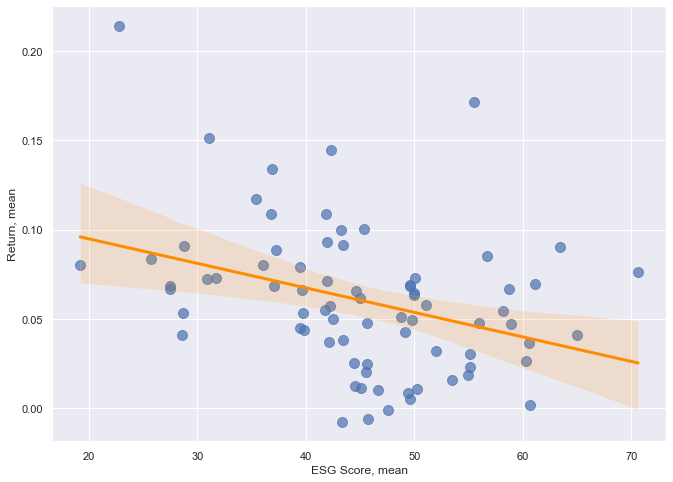

In [66]:
sns.set(rc={'figure.figsize':(11,8)})
sns.regplot(x=esg_esg.mean(),y=tab.loc['mean',:][:-3],
            line_kws={'lw': 3, 'color': 'darkorange'},
           scatter_kws={'s': 100, 'alpha': 0.7}); #Stocks with higest avg return
plt.xlabel('ESG Score, mean')
plt.ylabel('Return, mean')
plt.savefig('scatter.png');